# Comparison between Nestorov and normal momentum approaches 

## Import libreries and define global variables

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from utils import get_data, onehot_encoding, grid_search, save_dict_to_file, load_dict_from_file, cross_validation
from Layer import Layer, Input
from functions import accuracy, MSE, MEE
import pandas as pd

In [13]:
DIR = '/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/' # Directory of the package.

## Import datasets

### Import MONK datasets

In [14]:
df = get_data(f'{DIR}data/MONK/monks-1.train')
df_test = get_data(f'{DIR}data/MONK/monks-1.test')

X_train_monk, y_train_monk = df.drop(columns=['target','id']).to_numpy().T, df['target'].apply(lambda x: int(x)).to_numpy().T
X_test_monk, y_test_monk = df_test.drop(columns=['target','id']).to_numpy().T, df_test['target'].apply(lambda x: int(x)).to_numpy().T

### Import CUP dataset

Define the fraction of dataset which will represent the internal test set.

In [15]:
test_frac = 1/4

In [16]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv(f"{DIR}data/ML-CUP23-TR.csv", names=names, comment='#')

targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

df = df.sample(frac=1)

train_test_div = round((1-test_frac) * df.shape[0])

X_train_cup, y_train_cup = df[:train_test_div][features].to_numpy().T, df[:train_test_div][targets].to_numpy().T
X_test_cup, y_test_cup = df[train_test_div:][features].to_numpy().T, df[train_test_div:][targets].to_numpy().T

## Data preprocessing

### MONK preprocessing

Process one hot encoding on training and test sets.

In [17]:
X_train_monk = onehot_encoding(X_train_monk)
X_test_monk = onehot_encoding(X_test_monk)

### CUP preprocessing

Decide which data preprocessing method apply to cup training set:
+ MinMax normalization (preprocessing = 1)
+ Standardization (preprocessing = 2)

In [18]:
def standardize(input_array):
    """ Standardize each feature in an input array using Z-score standardization.

    Args:
        input_array (np.array): snput array with dimensions (features, samples).

    Returns:
        np.array: standardized input array.
    """
    mean_vals = np.mean(input_array, axis=1, keepdims=True)
    std_dev_vals = np.std(input_array, axis=1, keepdims=True)

    # Ensure no division by zero
    std_dev_vals[std_dev_vals == 0] += 1e-6

    standardized_array = (input_array - mean_vals) / std_dev_vals

    return standardized_array


In [19]:
def minmax_norm(input_array):
    """ Normalize each feature in an input array using minmax normalization.

    Args:
        input_array (np.array): input array with dimensions (features, samples).

    Returns:
        np.array: normalized input array.
    """    
    X_train_norm = []
    for elem in input_array:
        X_train_norm.append((elem - np.min(elem)) / (np.max(elem) - np.min(elem)))
    return np.array(X_train_norm)

In [20]:

X_train_norm = minmax_norm(X_train_cup)
X_test_norm = minmax_norm(X_test_cup)

X_train_stand = standardize(X_train_cup)
X_test_stand = standardize(X_test_cup)

## CUP

Define training and model hyperparameters

In [21]:
orig_params = {'hidden_dim': 50,
        'hidden_act_func': 'tanh',
        'hidden_dim2': 50,
        'hidden_act_func2' : 'tanh',
        'eta': 0.001,
        'lam': 0.000,
        'alpha': 0.9,
        'n_batch': 150,
        'use_opt':0,
        'nest': True,
        'l1_reg' : False,
        'epochs' : 500,
        'loss' : 'MSE',
        'output_act_func': 'lin'
        }
seed = np.random.randint(10,1000)

### No normalization

Build model

In [22]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

init_weights_list = model.get_weights_list()

Training:

In [23]:
np.random.seed(seed)
history_nonorm = model.train(X_train_cup, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 5.995e+02, val_loss: 6.013e+02; train_MEE: 3.695e+01, val_MEE: 3.750e+01  lr : 0.001


Epoch 1: train_loss: 3.236e+02, val_loss: 3.236e+02; train_MEE: 2.616e+01, val_MEE: 2.650e+01  lr : 0.001
Epoch 2: train_loss: 1.421e+02, val_loss: 1.358e+02; train_MEE: 1.739e+01, val_MEE: 1.703e+01  lr : 0.001
Epoch 3: train_loss: 6.234e+01, val_loss: 5.547e+01; train_MEE: 1.183e+01, val_MEE: 1.119e+01  lr : 0.001
Epoch 4: train_loss: 3.916e+01, val_loss: 3.686e+01; train_MEE: 9.789e+00, val_MEE: 9.549e+00  lr : 0.001
Epoch 5: train_loss: 2.824e+01, val_loss: 2.856e+01; train_MEE: 8.325e+00, val_MEE: 8.412e+00  lr : 0.001
Epoch 6: train_loss: 2.131e+01, val_loss: 2.251e+01; train_MEE: 7.157e+00, val_MEE: 7.304e+00  lr : 0.001
Epoch 7: train_loss: 1.580e+01, val_loss: 1.756e+01; train_MEE: 6.083e+00, val_MEE: 6.226e+00  lr : 0.001
Epoch 8: train_loss: 1.204e+01, val_loss: 1.436e+01; train_MEE: 5.227e+00, val_MEE: 5.470e+00  lr : 0.001
Epoch 9: train_loss: 9.673e+00, val_loss: 1.214e+01; train_MEE: 4.586e+00, val_MEE: 4.853e+00  lr : 0.001
Epoch 10: train_loss: 8.043e+00, val_loss: 1.0

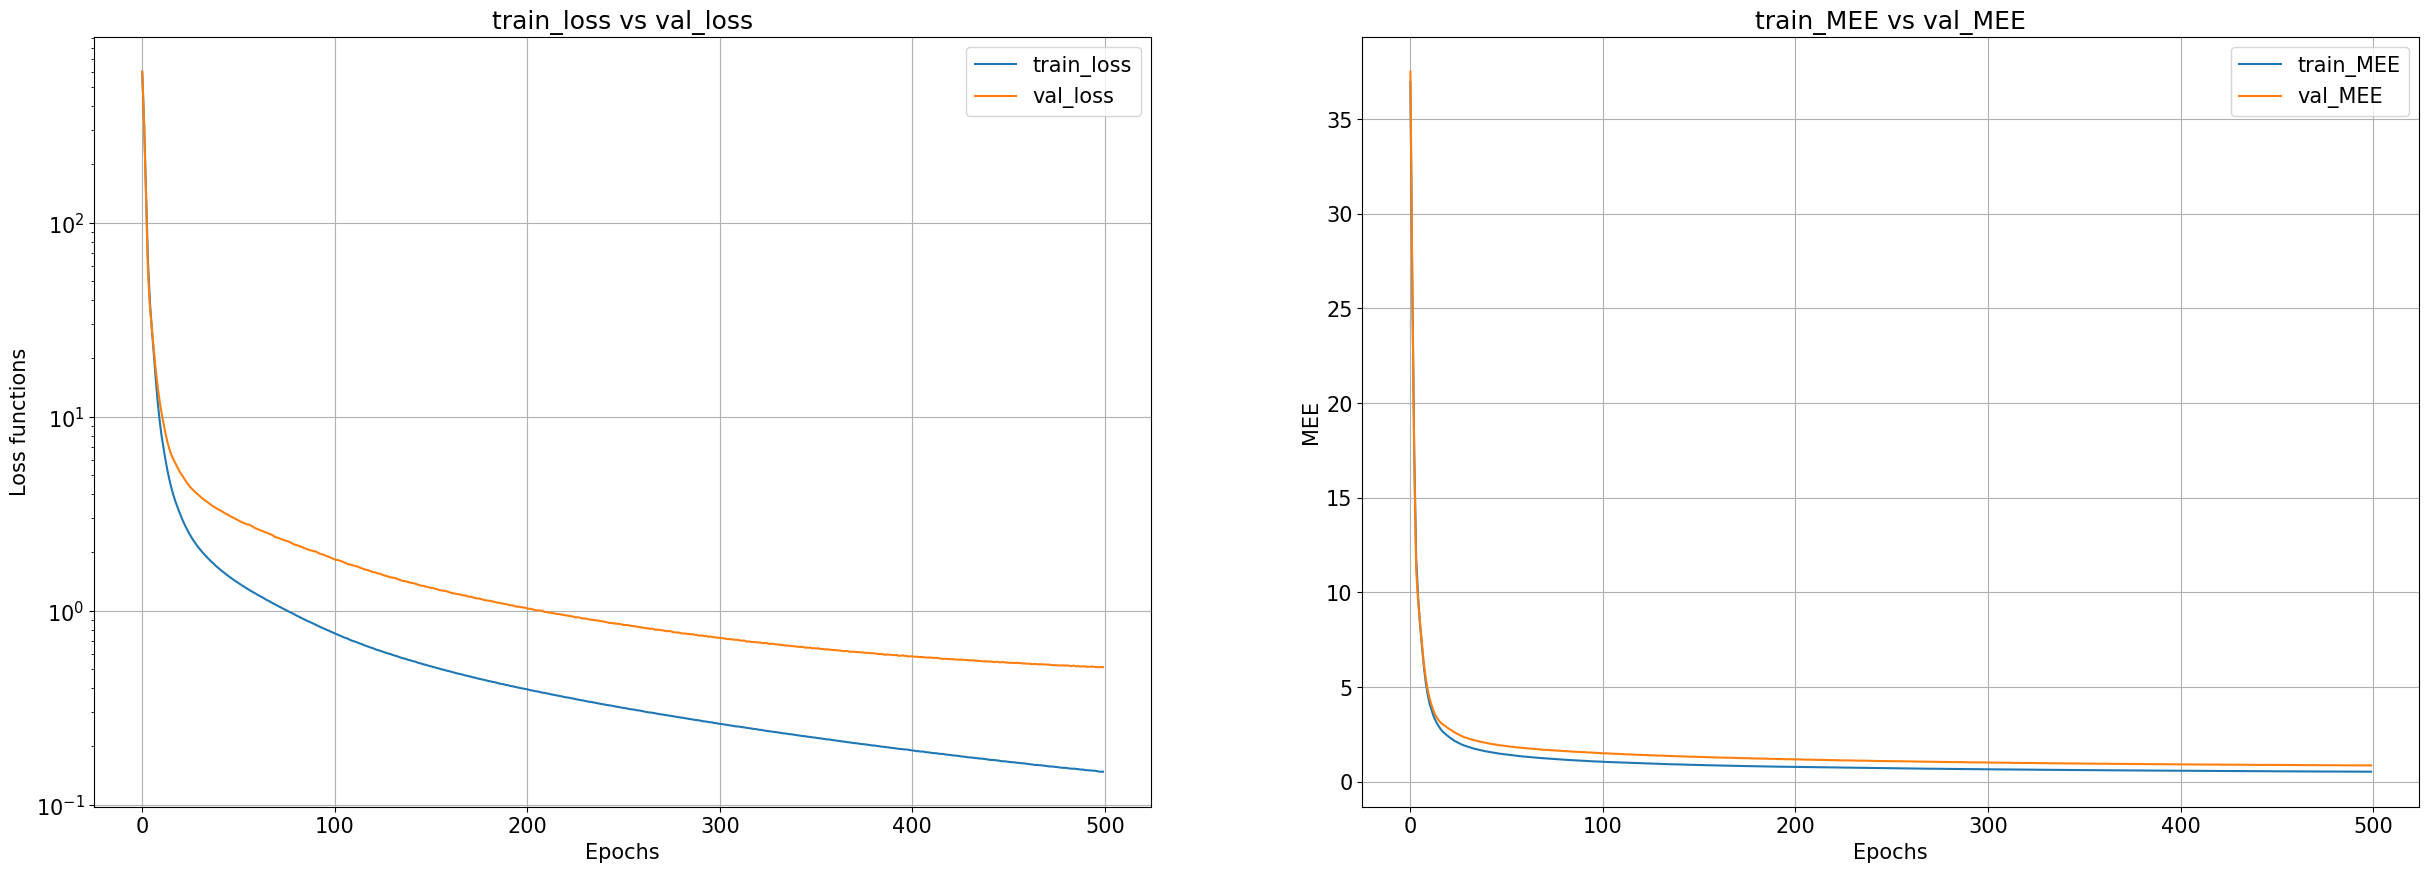

In [24]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_nonorm['train_loss'],label='train_loss')
plt.plot(history_nonorm['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_nonorm['train_MEE'],label='train_MEE')
plt.plot(history_nonorm['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

### minmax normalization


Build model


In [25]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [26]:
np.random.seed(seed)
history_norm = model.train(X_train_norm, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.156e+02, val_loss: 6.124e+02; train_MEE: 3.854e+01, val_MEE: 3.878e+01  lr : 0.001
Epoch 1: train_loss: 4.016e+02, val_loss: 3.942e+02; train_MEE: 3.157e+01, val_MEE: 3.134e+01  lr : 0.001
Epoch 2: train_loss: 2.015e+02, val_loss: 1.922e+02; train_MEE: 2.139e+01, val_MEE: 2.111e+01  lr : 0.001
Epoch 3: train_loss: 9.339e+01, val_loss: 8.469e+01; train_MEE: 1.435e+01, val_MEE: 1.388e+01  lr : 0.001
Epoch 4: train_loss: 5.333e+01, val_loss: 4.781e+01; train_MEE: 1.118e+01, val_MEE: 1.058e+01  lr : 0.001
Epoch 5: train_loss: 3.811e+01, val_loss: 3.607e+01; train_MEE: 9.618e+00, val_MEE: 9.385e+00  lr : 0.001
Epoch 6: train_loss: 3.011e+01, val_loss: 3.109e+01; train_MEE: 8.550e+00, val_MEE: 8.722e+00  lr : 0.001
Epoch 7: train_loss: 2.269e+01, val_loss: 2.432e+01; train_MEE: 7.318e+00, val_MEE: 7.492e+00  lr : 0.001
Epoch 8: train_loss: 1.600e+01, val_loss: 1.810e+01; train_MEE: 6.000e+00, val_MEE: 6.229e+00  lr : 0.001
Epoch 9: train_loss: 1.247e+01, val_loss: 1.46

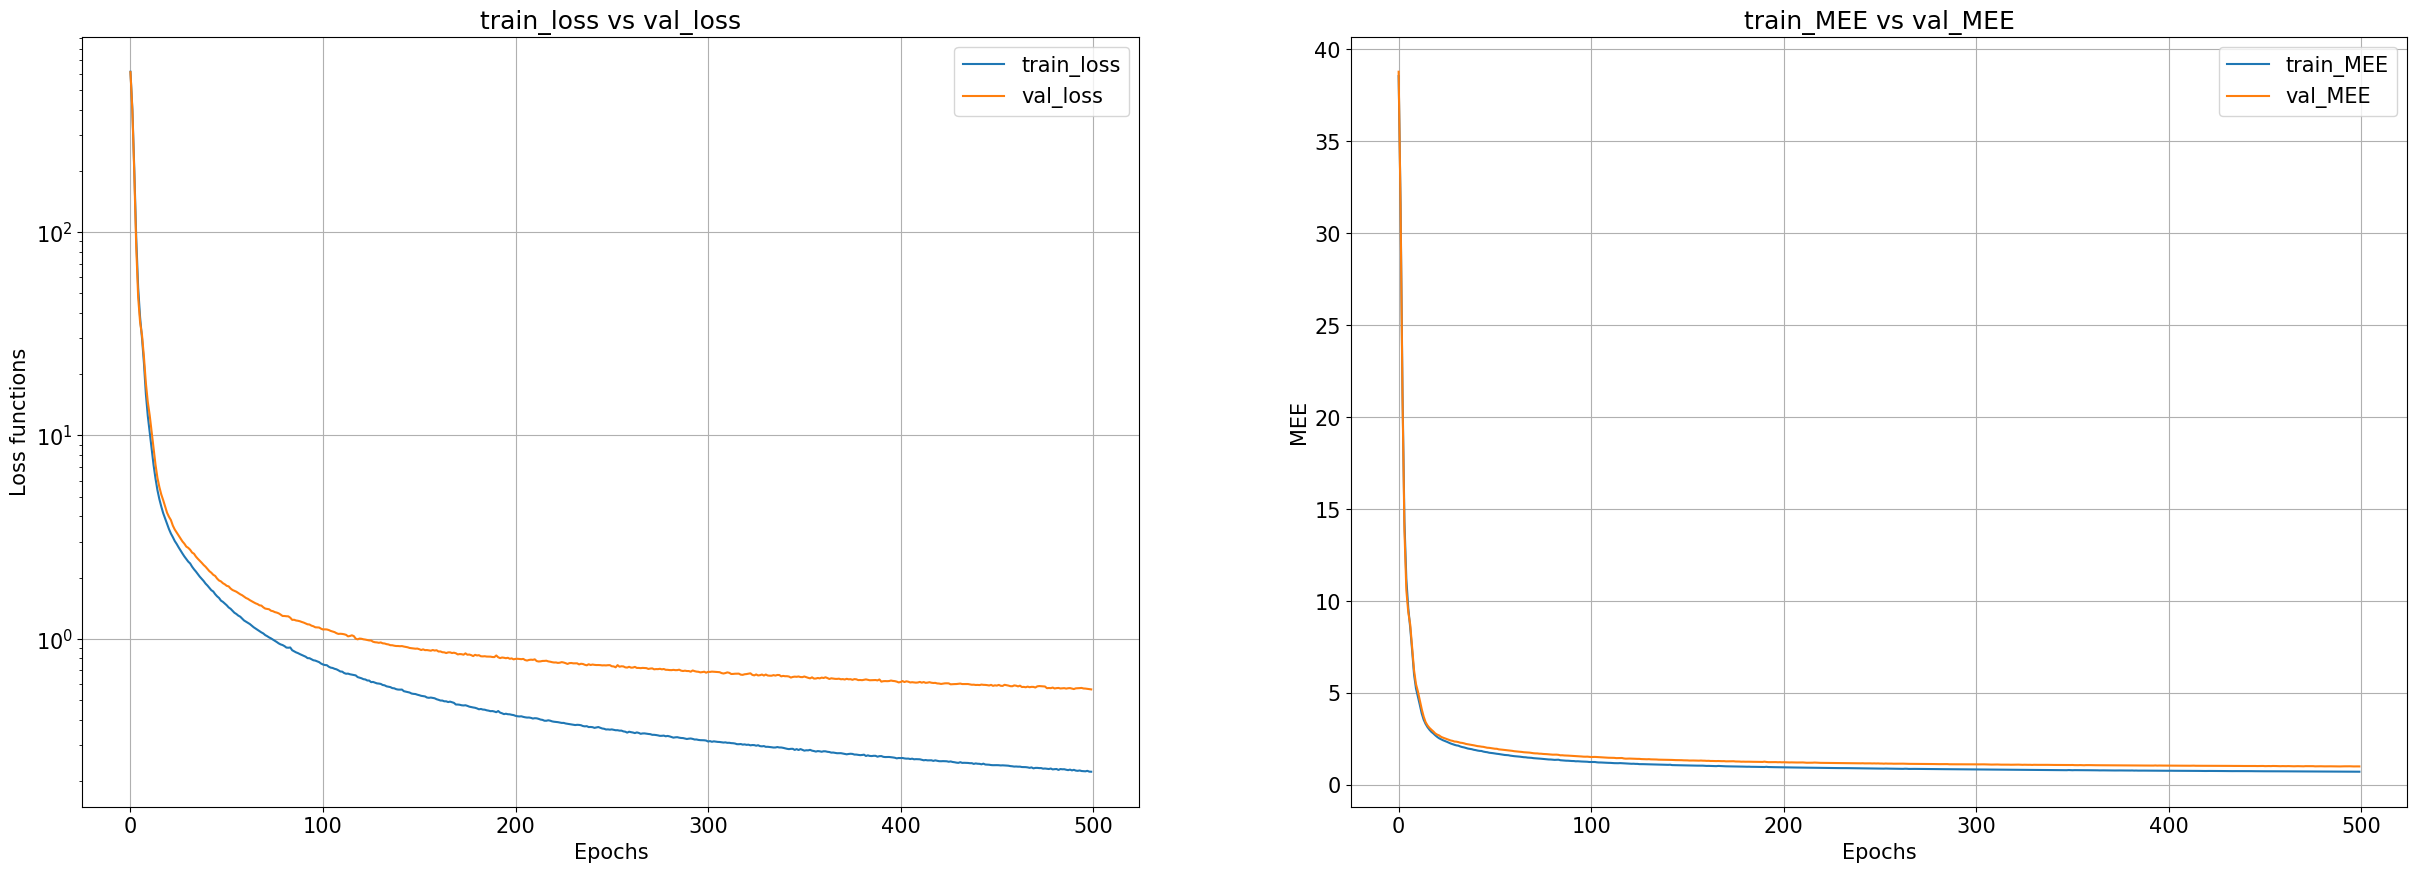

In [27]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_norm['train_loss'],label='train_loss')
plt.plot(history_norm['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_norm['train_MEE'],label='train_MEE')
plt.plot(history_norm['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### standardization


Build model


In [28]:
params = orig_params.copy()
input_layer = Input(X_train_cup.shape[0])
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
o = 2
while True:
    if f'hidden_dim{o}' in params.keys():
        hidden_layer = Layer(hidden_layer, params.pop(f'hidden_dim{o}'), params.pop(f'hidden_act_func{o}'))
        o += 1
    else: break
output_layer = Layer(hidden_layer, 3, params.pop('output_act_func'))

model = NeuralNetwork(input_layer, output_layer, params.pop('loss'), metrics=[MEE])

model.set_initial_weights(init_weights_list)

Training:


In [29]:
np.random.seed(seed)
history_stand = model.train(X_train_stand, y_train_cup,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 6.017e+02, val_loss: 6.046e+02; train_MEE: 3.729e+01, val_MEE: 3.788e+01  lr : 0.001
Epoch 1: train_loss: 3.239e+02, val_loss: 3.237e+02; train_MEE: 2.643e+01, val_MEE: 2.669e+01  lr : 0.001
Epoch 2: train_loss: 1.372e+02, val_loss: 1.297e+02; train_MEE: 1.704e+01, val_MEE: 1.646e+01  lr : 0.001
Epoch 3: train_loss: 6.452e+01, val_loss: 5.613e+01; train_MEE: 1.211e+01, val_MEE: 1.130e+01  lr : 0.001
Epoch 4: train_loss: 4.076e+01, val_loss: 3.839e+01; train_MEE: 9.854e+00, val_MEE: 9.709e+00  lr : 0.001
Epoch 5: train_loss: 2.796e+01, val_loss: 2.948e+01; train_MEE: 8.046e+00, val_MEE: 8.358e+00  lr : 0.001
Epoch 6: train_loss: 1.876e+01, val_loss: 2.133e+01; train_MEE: 6.402e+00, val_MEE: 6.759e+00  lr : 0.001
Epoch 7: train_loss: 1.552e+01, val_loss: 1.772e+01; train_MEE: 5.826e+00, val_MEE: 6.097e+00  lr : 0.001
Epoch 8: train_loss: 1.192e+01, val_loss: 1.368e+01; train_MEE: 5.080e+00, val_MEE: 5.306e+00  lr : 0.001
Epoch 9: train_loss: 9.057e+00, val_loss: 1.08

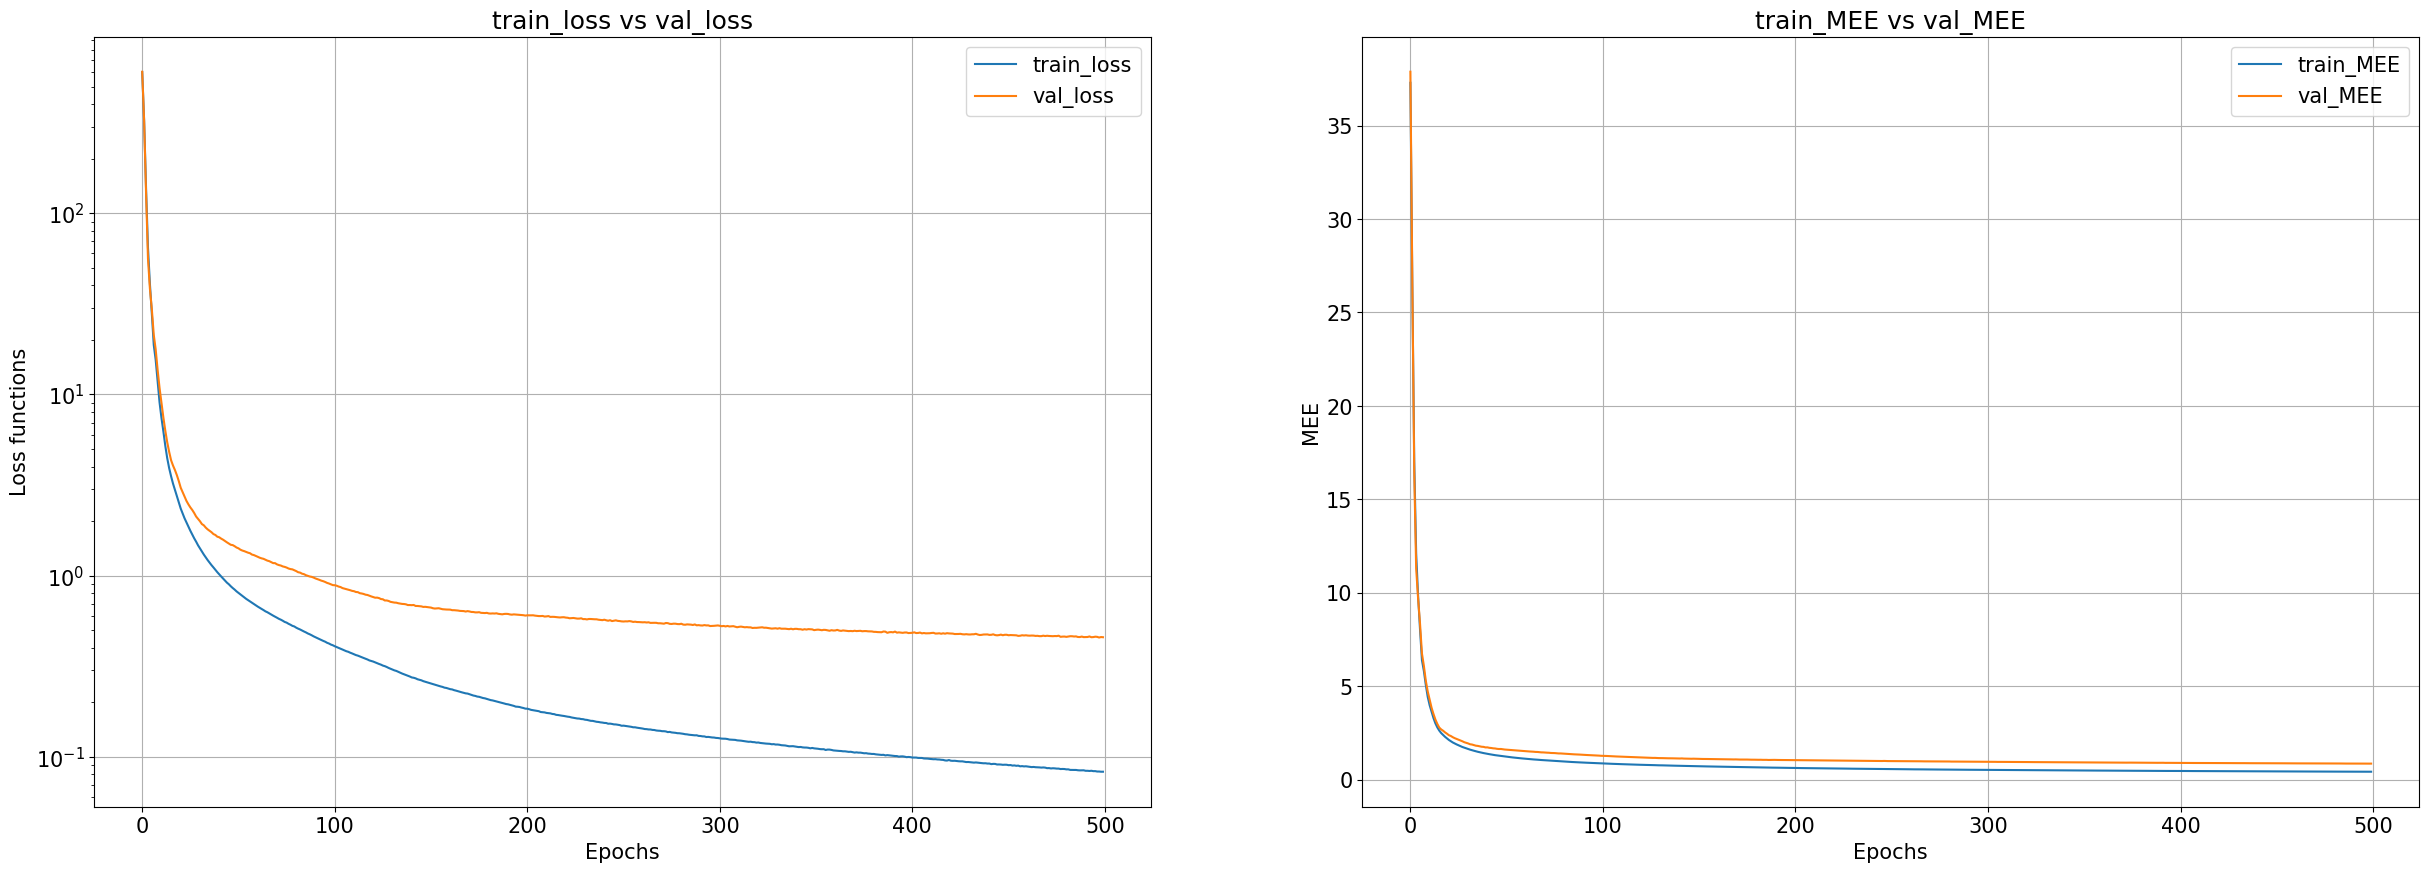

In [30]:
plt.figure(1,figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(history_stand['train_loss'],label='train_loss')
plt.plot(history_stand['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.subplot(1,2,2)
plt.plot(history_stand['train_MEE'],label='train_MEE')
plt.plot(history_stand['val_MEE'], label='val_MEE')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)


### Comparison

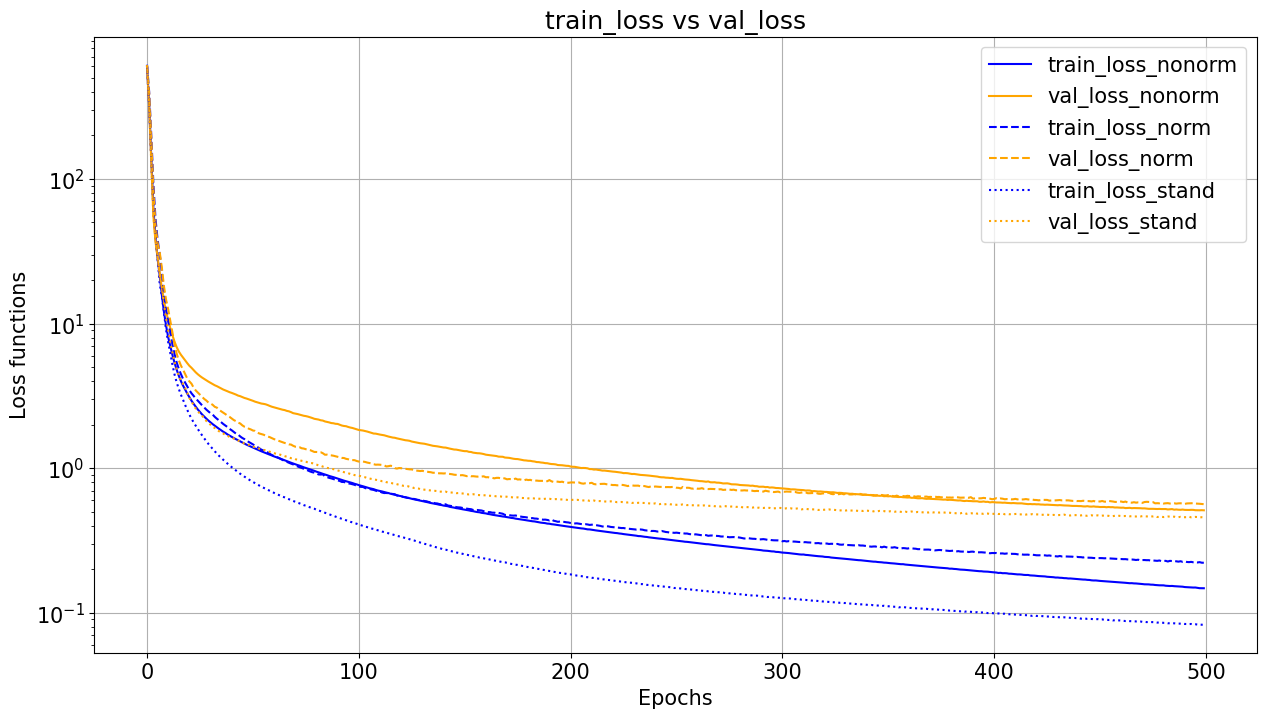

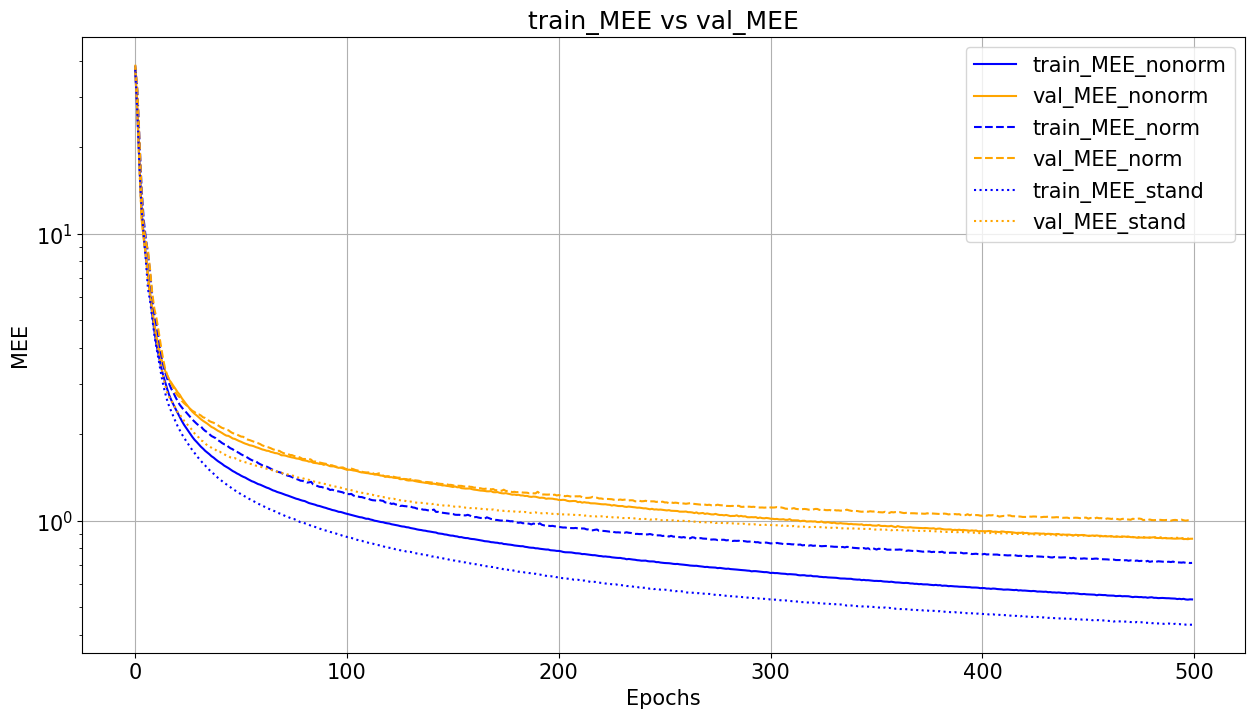

In [31]:
plt.figure(1,figsize=(15,8))
#plt.subplot(1,2,1)
plt.plot(history_nonorm['train_loss'], '-', label='train_loss_nonorm', color='blue')
plt.plot(history_nonorm['val_loss'], '-', label='val_loss_nonorm', color='orange')
plt.plot(history_norm['train_loss'], '--', label='train_loss_norm', color='blue')
plt.plot(history_norm['val_loss'], '--', label='val_loss_norm', color='orange')
plt.plot(history_stand['train_loss'], linestyle='dotted', label='train_loss_stand', color='blue')
plt.plot(history_stand['val_loss'], linestyle='dotted', label='val_loss_stand', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)
plt.figure(2,figsize=(15,8))
#plt.subplot(1,2,2)
plt.plot(history_nonorm['train_MEE'], '-',label='train_MEE_nonorm', color='blue')
plt.plot(history_nonorm['val_MEE'], '-', label='val_MEE_nonorm', color='orange')
plt.plot(history_norm['train_MEE'], '--', label='train_MEE_norm', color='blue')
plt.plot(history_norm['val_MEE'], '--', label='val_MEE_norm', color='orange')
plt.plot(history_stand['train_MEE'], linestyle='dotted', label='train_MEE_stand', color='blue')
plt.plot(history_stand['val_MEE'], linestyle='dotted', label='val_MEE_stand', color='orange')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

In [34]:
params = orig_params.copy()
params['loss'] = 'MSE'
params['output_act_func'] = 'lin'
params['scale_eta_batchsize'] = None
params['dim_hidden'] = params.pop('hidden_dim')
params['dim_hidden2'] = params.pop('hidden_dim2')
params['n_batch'] = 'batch'
print(params)
seed = np.random.randint(10,1000)
np.random.seed(seed)
history_cv_nonorm = cross_validation(X_train_cup, y_train_cup, folds=5, metrics=[MSE,MEE], params=params.copy(), callbacks={'early_stopping':None, 'reduce_eta':None})
np.random.seed(seed)
history_cv_norm = cross_validation(X_train_norm, y_train_cup, 5, [MSE,MEE], params=params.copy(), callbacks={'early_stopping':None, 'reduce_eta':None})
np.random.seed(seed)
history_cv_stand = cross_validation(X_train_stand, y_train_cup, 5, [MSE,MEE], params=params.copy(), callbacks={'early_stopping':None, 'reduce_eta':None})

{'hidden_act_func': 'tanh', 'hidden_act_func2': 'tanh', 'eta': 0.001, 'lam': 0.0, 'alpha': 0.9, 'n_batch': 'batch', 'use_opt': 0, 'nest': True, 'l1_reg': False, 'epochs': 500, 'loss': 'MSE', 'output_act_func': 'lin', 'scale_eta_batchsize': None, 'dim_hidden': 50, 'dim_hidden2': 50}


In [35]:
history_cv_nonorm

{'train_loss_mean': 0.4764387667226096,
 'train_loss_std': 0.04349240709238616,
 'val_loss_mean': 1.0098123611821566,
 'val_loss_std': 0.2350130213769577,
 'train_MSE_mean': 0.4764387667226096,
 'train_MSE_std': 0.04349240709238616,
 'val_MSE_mean': 1.0098123611821566,
 'val_MSE_std': 0.2350130213769577,
 'train_MEE_mean': 0.9113228192128258,
 'train_MEE_std': 0.035816885573869015,
 'val_MEE_mean': 1.2379003490733724,
 'val_MEE_std': 0.09425868516790378}

In [36]:
history_cv_norm

{'train_loss_mean': 0.606971375455504,
 'train_loss_std': 0.04690465245457047,
 'val_loss_mean': 0.9338960080343754,
 'val_loss_std': 0.18818305103534474,
 'train_MSE_mean': 0.606971375455504,
 'train_MSE_std': 0.04690465245457047,
 'val_MSE_mean': 0.9338960080343754,
 'val_MSE_std': 0.18818305103534474,
 'train_MEE_mean': 1.1435008002280367,
 'train_MEE_std': 0.029338324574152197,
 'val_MEE_mean': 1.365807791898568,
 'val_MEE_std': 0.09972938968320644}

In [37]:
history_cv_stand

{'train_loss_mean': 0.32463660908366265,
 'train_loss_std': 0.03744123839676418,
 'val_loss_mean': 0.843524352335417,
 'val_loss_std': 0.1367795951709889,
 'train_MSE_mean': 0.32463660908366265,
 'train_MSE_std': 0.03744123839676418,
 'val_MSE_mean': 0.843524352335417,
 'val_MSE_std': 0.1367795951709889,
 'train_MEE_mean': 0.8086715040533592,
 'train_MEE_std': 0.01897540630451035,
 'val_MEE_mean': 1.2308735711981742,
 'val_MEE_std': 0.05990344031671819}